In [8]:
import copy
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
plt.style.use('default')

import tqdm

from utils.model_measure import print_regression_measure

# 1. Dataset

In [9]:
from sklearn.datasets import load_diabetes
data_X, data_Y = load_diabetes(return_X_y=True, as_frame=False)

n_samples = len(data_X)

# sample weights
# rng = np.random.default_rng(seed=42)
# data_weight = rng.normal(loc=0.0, scale=1.0, size=n_samples)
# data_weight = np.abs(data_weight) + 1.0

train_idx, test_idx = train_test_split(range(n_samples), test_size=0.3, random_state=0)
train_X, test_X = data_X[train_idx], data_X[test_idx]
train_Y, test_Y = data_Y[train_idx], data_Y[test_idx]
# train_weight, test_weight = data_weight[train_idx], data_weight[test_idx]

print('\nShape of dataset:', data_X.shape, data_Y.shape,
      '\nShape of training set:', train_X.shape, train_Y.shape,
      '\nShape of testing set:', test_X.shape, test_Y.shape)


Shape of dataset: (442, 10) (442,) 
Shape of training set: (309, 10) (309,) 
Shape of testing set: (133, 10) (133,)


# 2 Early stop

utilizing warm start to gradually increase subtree

- `warm_start = True`: gradually increase subtree models for the previously trained random forest

Based on tested results, if fix the random seed (i.e., `random_state`), there is no difference of the prediction results for whether using `warm_start` or not.

## 2.1. Regarding warm start

In [10]:
import time
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

def rf_increment_training(data_X, data_Y, max_estimators=500, warm_start=True):
    '''
    gradually add decision trees for random forest model
    '''
    params = {
        'criterion'         : 'squared_error',
        'max_depth'         : None,
        'min_samples_split' : 2,
        'max_features'      : 1.0,
        'bootstrap'         : True,
        'oob_score'         : mean_squared_error,
        'n_jobs'            : 1,
        'random_state'      : None}
    
    # initialization
    model = RandomForestRegressor(n_estimators=1, warm_start=False, **params)
    model.fit(data_X, data_Y)
    
    model_li = []
    model_li.append(copy.deepcopy(model))
    
    for n_estimators in tqdm.tqdm(range(2, max_estimators+1)):
        # refit model
        model.set_params(n_estimators=n_estimators, warm_start=warm_start)
        model.fit(data_X, data_Y)
        
        model_li.append(copy.deepcopy(model))
        
    score = np.array([model.oob_score_ for model in model_li])
    
    return model_li, score
# =========================================================================
def subtree_predict_result(rf_li, data_X, subtree_idx=0):
    '''
    from a series of RF model with continuously increased subtrees,
    obtain the prediction results of a specific subtrees within every RF models
    '''
    predict = {}
    for ix, rf in enumerate(rf_li):
        if ix < subtree_idx:
            continue
        else:
            predict[ix] = rf.estimators_[subtree_idx].predict(data_X)
    
    return pd.DataFrame(predict)  
# =========================================================================

In [11]:
t1 = time.process_time()
model_li_ws, score_ws = rf_increment_training(data_X, data_Y, max_estimators=100, warm_start=True)

t2 = time.process_time()
model_li, score = rf_increment_training(data_X, data_Y, max_estimators=100, warm_start=False)

t3 = time.process_time()
print('\nTime used for training RFs with warm start:', t2-t1,
      '\nTime used for training RFs without warm start:', t3-t2)

100%|██████████| 99/99 [00:11<00:00,  8.81it/s]


Time used for training RFs with warm start: 0.1875 
Time used for training RFs without warm start: 3.390625


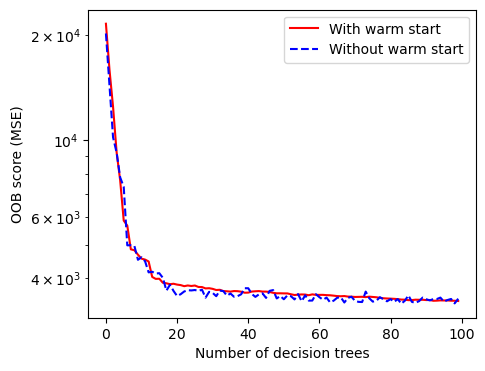

In [12]:
# plot oob score
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.plot(score_ws, color='red', label='With warm start')
ax.plot(score, color='blue', ls='--', label='Without warm start')
ax.legend()

ax.set_xlabel('Number of decision trees')
ax.set_ylabel('OOB score (MSE)')
ax.set_yscale('log')

#### Prediction results of subtrees

**Assumption:** if the subtree at the same sequential locations (i.e., same indices) of RF models have the same prediction results (as a proxy of model parameters), the "warm start" utilizes the gradually adding decision trees approach to train a RF model

In [13]:
for i in range(0, 20):
    print('\nSubsequent index of subtree:', i)
           
    # with warm start
    predict = subtree_predict_result(model_li_ws, data_X, subtree_idx=i)
    pred_std = predict.std(axis=1)
    print(pred_std.min(), pred_std.max())
    
    # without warm start
    predict = subtree_predict_result(model_li, data_X, subtree_idx=i)
    pred_std = predict.std(axis=1)
    print(pred_std.min(), pred_std.max())


Subsequent index of subtree: 0
0.0 0.0
12.277037776501974 107.06704403873266

Subsequent index of subtree: 1
0.0 0.0
10.270742269858642 90.42339083660603

Subsequent index of subtree: 2
0.0 0.0
10.499100780026055 95.45482439849108

Subsequent index of subtree: 3
0.0 0.0
9.600000447451308 95.62902732799071

Subsequent index of subtree: 4
0.0 0.0
13.004010009062185 97.71544796975462

Subsequent index of subtree: 5
0.0 0.0
12.36243451889807 102.430045502892

Subsequent index of subtree: 6
0.0 0.0
11.379962482332301 106.37871777099393

Subsequent index of subtree: 7
0.0 0.0
11.477349280956124 98.90336044749634

Subsequent index of subtree: 8
0.0 0.0
13.875715311081118 108.61591717134195

Subsequent index of subtree: 9
0.0 0.0
14.237716681848122 96.35233598399495

Subsequent index of subtree: 10
0.0 0.0
13.776352570159068 96.08267091644026

Subsequent index of subtree: 11
0.0 0.0
14.173744952032635 99.35152097024546

Subsequent index of subtree: 12
0.0 0.0
13.032051959128031 96.39605042269

## 2.2 Early stopped Random Forest

In [14]:
from utils.rf_model import training_random_forest_early_stop

params = {
    'criterion'         : 'squared_error',
    'max_depth'         : 5,
    'min_samples_split' : 6,
    'max_features'      : 1.0,
    'bootstrap'         : True,
    'oob_score'         : mean_squared_error,
    'n_jobs'            : 1,
    'random_state'      : 42}

model, oob_score = training_random_forest_early_stop(
    data_X = train_X, 
    data_Y = train_Y,
    max_estimators = 1000, n_iter_no_change=50, 
    return_logs = True,
    refit = True,
    **params)

print('Optimal number of estimators:', model.get_params()['n_estimators'])

train_Y_pred = model.predict(train_X)
test_Y_pred  = model.predict(test_X)

print_regression_measure(train_Y, train_Y_pred)
print_regression_measure(test_Y, test_Y_pred)

Optimal number of estimators: 60
 MAE : 31.733
 MSE : 1489.272
RMSE : 38.591
MAPE : 0.294
  R2 : 0.763
 MAE : 46.899
 MSE : 3465.631
RMSE : 58.87
MAPE : 0.409
  R2 : 0.321
